# SpatialEx+ Enables Spatial Multi-omics through Omics Diagonal Integration (transcriptomics-metabolomics)

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

import preprocess as pp
from utils import Compute_metrics, Compute_MoransI

## 1. Train SpatialEx+

In [2]:
!python omics_diagonal_integration_rna_metabolism.py --device 4

Namespace(activation='elu', alpha_l=2, attn_drop=0.1, batch_size=4096, beta_l=1, cell_diameter=-1, decoder='linear', deg4feat=False, device=4, drop_edge_rate=0.0, encoder='hgnn', epoch=600, file_path1='/home/wcy/code/datasets/Visium/Multi_modality/rna_V11L12-109_C1.h5ad', file_path2='/home/wcy/code/datasets/Visium/Multi_modality/New/metabolite_V11L12-109_B1.h5ad', graph_kind='spatial', hidden_dim=512, image_encoder='uni', img_batch_size=64, img_path1='/home/wcy/code/datasets/Visium/Multi_modality/220506_MSi_V11L12-109_C1.jpg', img_path2='/home/wcy/code/datasets/Visium/Multi_modality/220506_MSi_V11L12-109_B1.jpg', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='mse', loss_num=6, lr=0.001, mask_gene_rate=0.8, negative_slope=0.2, norm='batchnorm', num_features=[1000, 50], num_heads=4, num_layers=2, num_neighbors=2, num_out_heads=1, optimizer='adam', output_folder='/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/', platform='Visium', pooli

## 2. Read in references: feat_names, cell_coor 

In [3]:
metabolite_names = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/panel/MSA_metabolite_selection.npy', allow_pickle=True)
rna_names = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/panel/MSA_RNA_selection.npy', allow_pickle=True)
B1_coor = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/V11L12-109_B1_cell_coor_out_spot.csv', index_col=0)
C1_coor = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/V11L12-109_C1_cell_coor_out_spot.csv', index_col=0)

In [4]:
B1_metabolite = sc.read_h5ad('/home/wcy/code/datasets/Visium/Multi_modality/New/metabolite_V11L12-109_B1.h5ad')
B1_metabolite.var_names = B1_metabolite.var['metabolism'].values
B1_metabolite.var_names_make_unique()
B1_metabolite = B1_metabolite[:, metabolite_names]
B1_metabolite = pp.Preprocess_adata(B1_metabolite, cell_mRNA_cutoff=0, scale=True)
if isinstance(B1_metabolite.X, sp.csr_matrix):
    B1_metabolite.X = B1_metabolite.X.A  
    
C1_metabolite = sc.read_h5ad('/home/wcy/code/datasets/Visium/Multi_modality/New/metabolite_V11L12-109_C1.h5ad')
C1_metabolite.var_names = C1_metabolite.var['metabolism'].values
C1_metabolite.var_names_make_unique()
C1_metabolite = C1_metabolite[:, metabolite_names]
C1_metabolite = pp.Preprocess_adata(C1_metabolite, cell_mRNA_cutoff=0, scale=True)
if isinstance(C1_metabolite.X, sp.csr_matrix):
    C1_metabolite.X = C1_metabolite.X.A  
    
B1_rna = sc.read_h5ad('/home/wcy/code/datasets/Visium/Multi_modality/New/rna_V11L12-109_B1.h5ad')
B1_rna.var_names_make_unique()
B1_rna = B1_rna[:, rna_names]
sc.pp.log1p(B1_rna)
B1_rna = pp.Preprocess_adata(B1_rna, cell_mRNA_cutoff=0, scale=True)
if isinstance(B1_rna.X, sp.csr_matrix):
    B1_rna.X = B1_rna.X.A  

C1_rna = sc.read_h5ad('/home/wcy/code/datasets/Visium/Multi_modality/New/rna_V11L12-109_C1.h5ad')
C1_rna.var_names_make_unique()
C1_rna = C1_rna[:, rna_names]
sc.pp.log1p(C1_rna)
C1_rna = pp.Preprocess_adata(C1_rna, cell_mRNA_cutoff=0, scale=True)
if isinstance(C1_rna.X, sp.csr_matrix):
    C1_rna.X = C1_rna.X.A   

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
C1_inner_x, C1_inner_y = C1_metabolite.obsm['spatial'][:, 0], C1_metabolite.obsm['spatial'][:, 1]
C1_outer_x, C1_outer_y = C1_coor['image_col'].values, C1_coor['image_row'].values
B1_inner_x, B1_inner_y = B1_rna.obsm['spatial'][:, 0], B1_rna.obsm['spatial'][:, 1]
B1_outer_x, B1_outer_y = B1_coor['image_col'].values, B1_coor['image_row'].values

## 3. Visualize gene expression

In [6]:
B1_rna_inner = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/rna_B1.npy')
B1_rna_outer = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/rna_B1_out.npy')
C1_rna_inner = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/rna_C1.npy')
C1_rna_outer = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/rna_C1_out.npy')
B1_rna_outer.shape

(331, 1000)

## 3.1 SpatialEx+ expands gene expression to the whole slide image wide

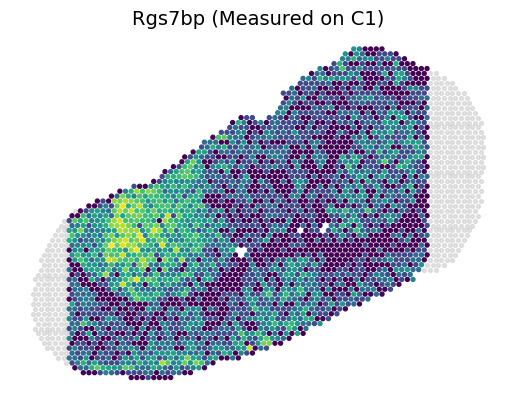

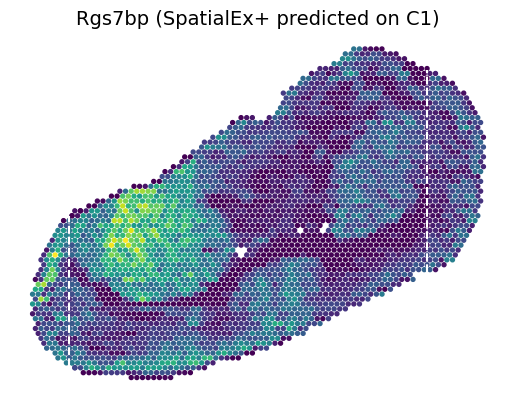

In [7]:
feat_name = 'Rgs7bp'
feat_idx = np.where(rna_names == feat_name)[0]

value = C1_rna[:,feat_name].X
vmin, vmax = value.min(), value.max()
plt.scatter(C1_inner_x, C1_inner_y, c=value, s=8, zorder=2)
plt.scatter(C1_outer_x, C1_outer_y, s=8, zorder=1, facecolors='grey', edgecolors='grey', alpha=0.2, linewidth=1)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
# plt.colorbar()
plt.title(feat_name + ' (Measured on C1)', fontsize=14)
plt.show()

value = C1_rna_inner[:,feat_idx]
plt.scatter(C1_inner_x, C1_inner_y, c=value, vmin=0.1, vmax=0.9, s=8, zorder=2)
value = C1_rna_outer[:,feat_idx]
plt.scatter(C1_outer_x, C1_outer_y, c=value, vmin=0.1, s=8, zorder=1)
plt.plot([C1_inner_x.min(), C1_inner_x.min()], [8600, 24000], c='white', linestyle='--')
plt.plot([C1_inner_x.max(), C1_inner_x.max()], [18200, 39000], c='white', linestyle='--')
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
# plt.colorbar()
plt.title(feat_name + ' (SpatialEx+ predicted on C1)', fontsize=14)
plt.show()

### 3.2 SpatialEx+ imputes the gene expression on the other slice

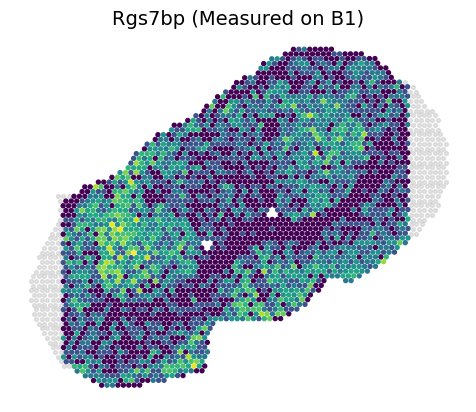

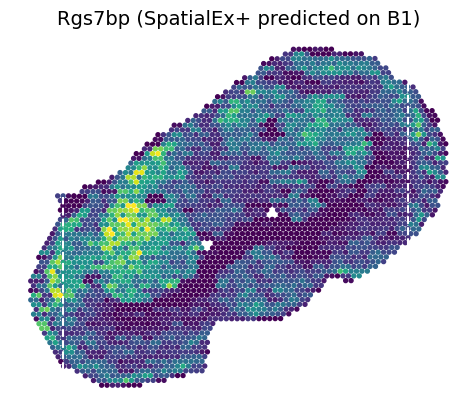

In [8]:
feat_name = 'Rgs7bp'
feat_idx = np.where(rna_names == feat_name)[0]

value = B1_rna[:,feat_name].X
vmin, vmax = value.min(), value.max()
plt.scatter(B1_inner_x, B1_inner_y, c=value, s=8, zorder=2)
plt.scatter(B1_outer_x, B1_outer_y, s=8, zorder=1, facecolors='grey', edgecolors='grey', alpha=0.2, linewidth=1)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.title(feat_name + ' (Measured on B1)', fontsize=14)
plt.show()

value = B1_rna_inner[:,feat_idx]
plt.scatter(B1_inner_x, B1_inner_y, vmin=0.1, vmax=1, c=value, s=8, zorder=2)
value = B1_rna_outer[:,feat_idx]
plt.scatter(B1_outer_x, B1_outer_y, vmin=0.1, c=value, s=8, zorder=1)

plt.plot([B1_inner_x.min(), B1_inner_x.min()], [8000, 26500], c='white', linestyle='--')
plt.plot([B1_inner_x.max(), B1_inner_x.max()], [21200, 38500], c='white', linestyle='--')
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.title(feat_name + ' (SpatialEx+ predicted on B1)', fontsize=14)
plt.show()

## 4. Visualize metabolites expression

In [9]:
B1_metabolite_inner = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/metabolite_B1.npy')
B1_metabolite_outer = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/metabolite_B1_out.npy')
C1_metabolite_inner = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/metabolite_C1.npy')
C1_metabolite_outer = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/upload_file/Output/Tutorial4/metabolite_C1_out.npy')
B1_metabolite_outer.shape

(331, 50)

### 4.1 SpatailEx+ expands the metabolites to the whole slide image wide

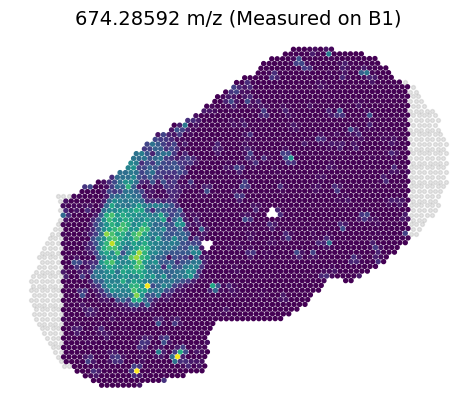

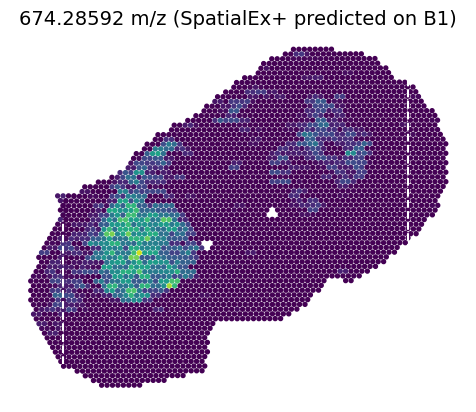

In [10]:
feat_name = '674.28592'
feat_idx = np.where(B1_metabolite.var_names == feat_name)[0]

value = B1_metabolite[:,feat_name].X
plt.scatter(B1_inner_x, B1_inner_y, c=value, s=8, zorder=2)
plt.scatter(B1_outer_x, B1_outer_y, s=8, zorder=1, facecolors='grey', edgecolors='grey', alpha=0.2, linewidth=1)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.title(feat_name+' m/z (Measured on B1)', fontsize=14)
plt.show()

value = B1_metabolite_inner[:,feat_idx]
plt.scatter(B1_inner_x, B1_inner_y, c=value, vmin=0.05, vmax=0.6, s=8, zorder=2)
value = B1_metabolite_outer[:, feat_idx]
plt.scatter(B1_outer_x, B1_outer_y, c=value, vmin=0.1, vmax=2, s=8, zorder=1)
plt.plot([B1_inner_x.min(), B1_inner_x.min()], [8600, 24000], c='white', linestyle='--')
plt.plot([B1_inner_x.max(), B1_inner_x.max()], [18200, 39000], c='white', linestyle='--')
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
# plt.colorbar()
plt.title(feat_name+' m/z (SpatialEx+ predicted on B1)', fontsize=14)
plt.show()

### 4.2 SpatailEx+ predicts the metabolites on the other slice

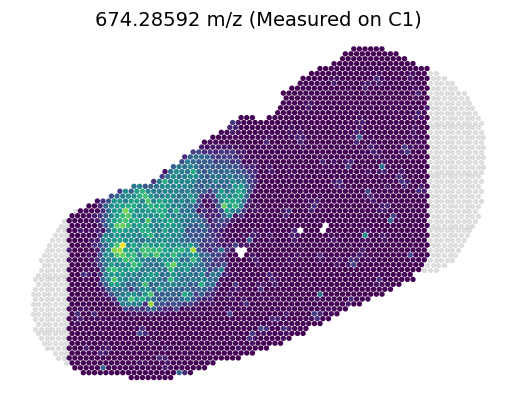

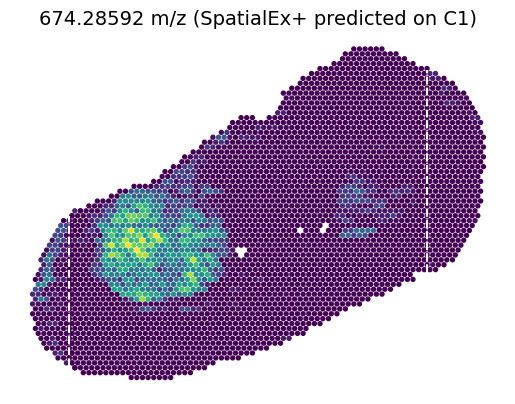

In [11]:
feat_name = '674.28592'
feat_idx = np.where(C1_metabolite.var_names == feat_name)[0]

value = C1_metabolite[:,feat_name].X
plt.scatter(C1_inner_x, C1_inner_y, c=value, s=8, zorder=2)
plt.scatter(C1_outer_x, C1_outer_y, s=8, zorder=1, facecolors='grey', edgecolors='grey', alpha=0.2, linewidth=1)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.title(feat_name+' m/z (Measured on C1)', fontsize=14)
plt.show()

value = C1_metabolite_inner[:,feat_idx]
plt.scatter(C1_inner_x, C1_inner_y, c=value, vmin=0.05, s=8, zorder=2)
value = C1_metabolite_outer[:, feat_idx]
plt.scatter(C1_outer_x, C1_outer_y, c=value, vmin=0.05, vmax=1, s=8, zorder=1)
plt.plot([C1_inner_x.min(), C1_inner_x.min()], [8600, 24000], c='white', linestyle='--')
plt.plot([C1_inner_x.max(), C1_inner_x.max()], [18200, 39000], c='white', linestyle='--')
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.title(feat_name+' m/z (SpatialEx+ predicted on C1)', fontsize=14)
plt.show()